In [1]:
#from phi.flow import *
from phi.torch.flow import *

In [103]:
DOMAIN = Box(x=math.PI, y=math.PI) # Original Domain Size
S = (50, 50) # Sampling size
DIM = 2

# Number of basis fields
N = 4**2
# Initialize basis fields
# Assume N is a perfect square, and use all basis fields
#  with wave number (k1,k2) up to (sqrt(N), sqrt(N))
# First, generate the data as a NumPy array
# dimensions: N x [k1,k2,eig] -> N x 3
N_sqrt = int(math.sqrt(N))
basis_np = [[float(k1), float(k2), -(k1**2 + k2**2)] for k1 in range(1, N_sqrt+1) for k2 in range(1, N_sqrt+1)]
basis_fields = math.tensor(basis_np, instance(i=N), channel(k='k1,k2,eig'))

print("basis_fields:\n{}".format(basis_fields.numpy('i,k')))

# basis coefficients as NumPy array
w_np = np.array(np.array([1.0 if i == 3 or i==2 or i==5else 0. for i in range(N)]))
w = math.tensor(torch.from_numpy(w_np))

print("w = {}".format(w.numpy()))

<Figure size 1200x500 with 3 Axes>

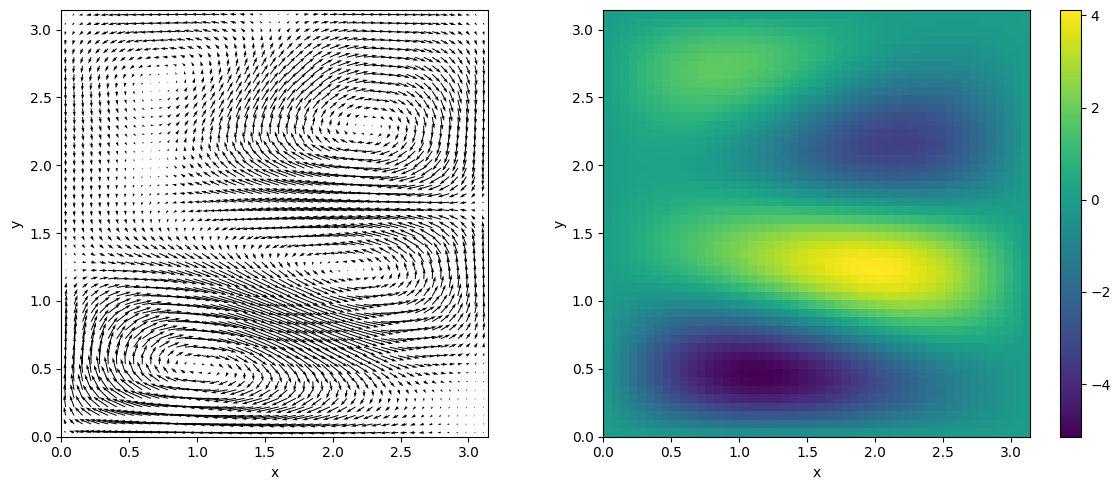

In [166]:
def phi(p):
    vel = math.zeros_like(p)
    for i in range(N):
        k1, k2, eig = basis_fields.i[i]
        k1x, k2y = k1*p.vector['x'], k2*p.vector['y']
        # note: we could store this factor
        fact = 2/math.PI/math.sqrt(-eig)
        vel += w[i] * tensor([
            -fact * k2 * math.sin(k1x) * math.cos(k2y),
            +fact * k1 * math.cos(k1x) * math.sin(k2y)
        ], channel(vector='x,y'))
    return vel

# The sampled, discrete current velocity field
# Currently sampling at cell centers
# In the future, maybe sample it in staggered form (https://tum-pbs.github.io/PhiFlow/Staggered_Grids.html)
#velocity = CenteredGrid((0,0), extrapolation.BOUNDARY, x=S[0], y=S[1], bounds=Box(x=DOMAIN[0], y=DOMAIN[1]))
velocity = CenteredGrid(phi, extrapolation.BOUNDARY, x=S[0], y=S[1], bounds=DOMAIN)

vis.plot([velocity * 0.2, field.curl(velocity)])

In [168]:
smoke = CenteredGrid(Box(x=[1,2], y=[1,2]), extrapolation.BOUNDARY, x=200, y=200, bounds=DOMAIN)
pressure = None

trajectory = [smoke]
for i in range(40):
    print(i, end=' ')
    smoke = advect.mac_cormack(smoke, velocity, dt=.1)
    trajectory.append(smoke)

trajectory = field.stack(trajectory, batch('time'))
vis.plot([velocity * 0.2,trajectory], animate='time')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 

<Figure size 640x480 with 0 Axes>